In [148]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [67]:
df_evadidos = pd.read_csv('./outputs/dropout.csv', index_col=0)
df_formados = pd.read_csv('./outputs/graduated.csv', index_col=0)

In [68]:
df_formados[["Tipo_Escola_Origem", "Reserva vaga"]]

,Tipo_Escola_Origem,Reserva vaga
indice,,
3,E,Ampla Concorrência
26,E,Ampla Concorrência
58,E,Ampla Concorrência
60,E,Ampla Concorrência
62,E,Ampla Concorrência
...,...,...
3293,E,"L2 Esc Publica, Renda<1.5sm, Raca"
3305,P,Não possui
3308,E,Ampla Concorrência


###  Junção dos datasets (Formados e Evadidos)

In [69]:
dataset = pd.concat([df_formados,df_evadidos], axis=0)

In [70]:
dataset.columns.values.tolist()

['Fluxo Escolar - Label',
 'Campus (Nome)',
 'Matrícula retida?',
 'Ingressantes em (Período Letivo)',
 'Modalidade do Curso',
 'Nível de Ensino',
 'Tipo de Modalidade (grupo)',
 'Cidade Aluno',
 'Cód. da Matriz',
 'Cód. do Curso',
 'Data Final Período',
 'Data Início Período',
 'Data Última Alteração Matrícula',
 'Dt Ref Início Matrícula',
 'Dt Ref Início Período Letivo',
 'Estado Aluno',
 'Estrutura Etária',
 'Etnia',
 'Faixa Etária',
 'Forma de Ingresso',
 'Forma de Oferta (grupo)',
 'Ingressantes em  (Ano Letivo)',
 'Num Seq deste Período Letivo',
 'Periodo Letivo (Num)',
 'Previsão de Término (Letivo)',
 'Reserva vaga',
 'Sexo',
 'Tipo de Modalidade',
 'Tipo_Escola_Origem',
 'É matrícula retida neste período letivo?',
 'Última Alteração de Situação',
 'CH',
 'CH. Disc. Obrigatórias',
 'CH. Disc. Optativas',
 'Duracao curso',
 'Idade (Hoje)',
 'Periodos Cursados']

### Formatação de Dados (Romero)

In [71]:
dataset = dataset.drop(columns=["Campus (Nome)"])

#### Conversões p/ binários

In [72]:
dataset["Fluxo Escolar - Label"] = dataset["Fluxo Escolar - Label"].map({'Formados': 1, 'Evadidos': 0})

In [73]:
dataset["Cidade Aluno"] = dataset["Cidade Aluno"].map(lambda cidade: 1 if cidade == 'Acaraú' else 0)

In [74]:
dataset["Sexo"] = dataset["Sexo"].map({'M': 0, 'F': 1})

In [75]:
# dataset["Tipo_Escola_Origem"] = dataset["Tipo_Escola_Origem"].map(lambda cidade: 1 if cidade != 'P' else 0)

In [107]:
dataset["Previsão de Término (Letivo)"] = dataset["Previsão de Término (Letivo)"].map(lambda data: int(data.replace("/","")))

In [113]:
dataset["previsao_ultrapassada"] =  dataset["Previsão de Término (Letivo)"] < dataset["Periodo Letivo (Num)"]

In [ ]:
dataset["previsao_ultrapassada"] = dataset["previsao_ultrapassada"].map({True: 1, False: 0})

##### Dataset Final

In [122]:
dataset_final = dataset[["Fluxo Escolar - Label","Cidade Aluno", "Sexo", "previsao_ultrapassada", 'Nível de Ensino', 'Reserva vaga', 'Etnia', 'Faixa Etária']]

In [123]:
b_encoder = ce.BinaryEncoder(cols=['Nível de Ensino', 'Reserva vaga', 'Etnia', 'Faixa Etária'])

In [127]:
dataset_final = b_encoder.fit_transform(dataset_final)

In [128]:
matriz_correlacao = dataset_final.corr()

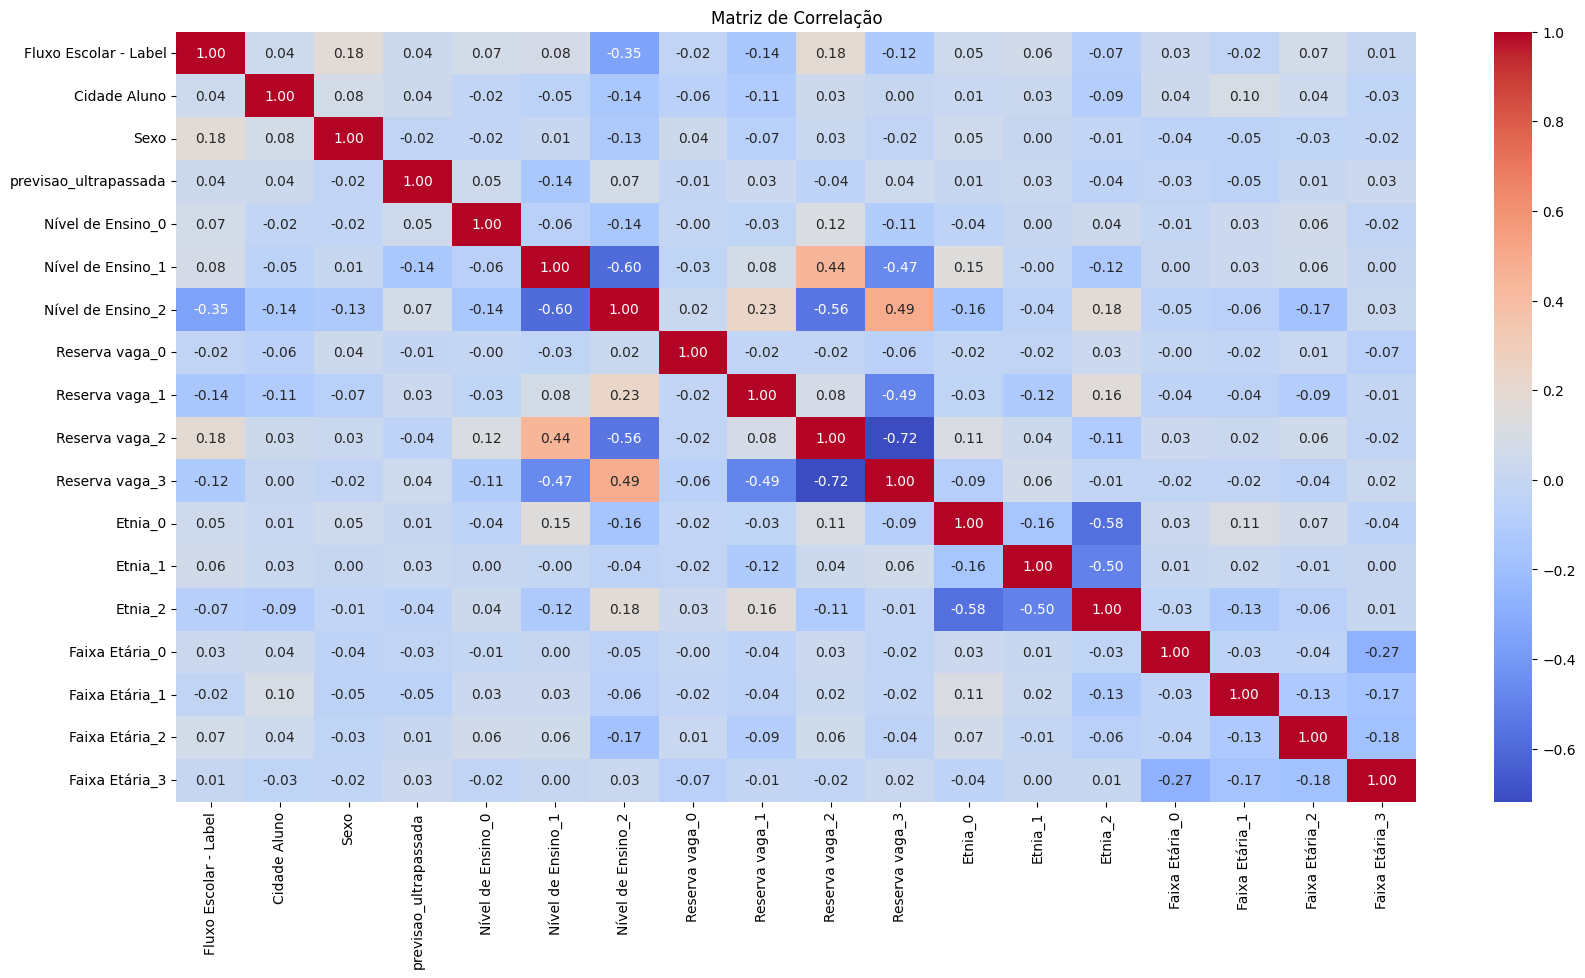

In [130]:
plt.figure(figsize=(20,10))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

### Algoritmo: Random Forest

#### Divisão dos dados

In [134]:
X = dataset_final.drop('Fluxo Escolar - Label', axis=1)
y = dataset_final['Fluxo Escolar - Label']

In [135]:
# Dividir o dataset em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [136]:
# Configurar o modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,          # Número de árvores na floresta
    max_depth=5,               # Profundidade máxima de cada árvore
    min_samples_split=4,       # Número mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=2,        # Número mínimo de amostras que uma folha (nó terminal) deve ter
    class_weight='balanced',   # Ajusta os pesos para lidar com classes desbalanceadas
    random_state=42            # Para reprodutibilidade
)


In [137]:
# Treinar o modelo
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=4, random_state=42)

In [140]:
# Fazer predições no conjunto de teste
y_pred = rf_model.predict(X_test)

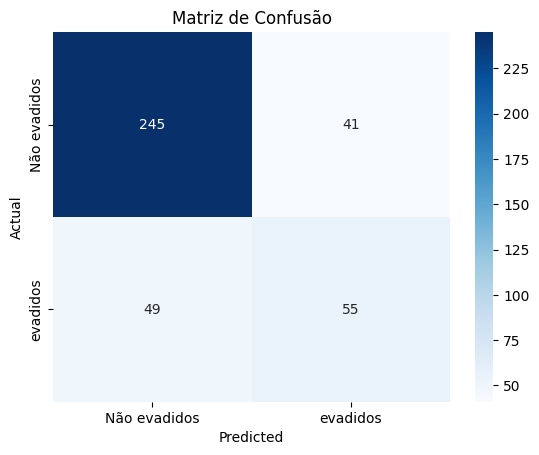

In [141]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Não evadidos', 'evadidos'], yticklabels=['Não evadidos', 'evadidos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusão')
plt.show()

In [144]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

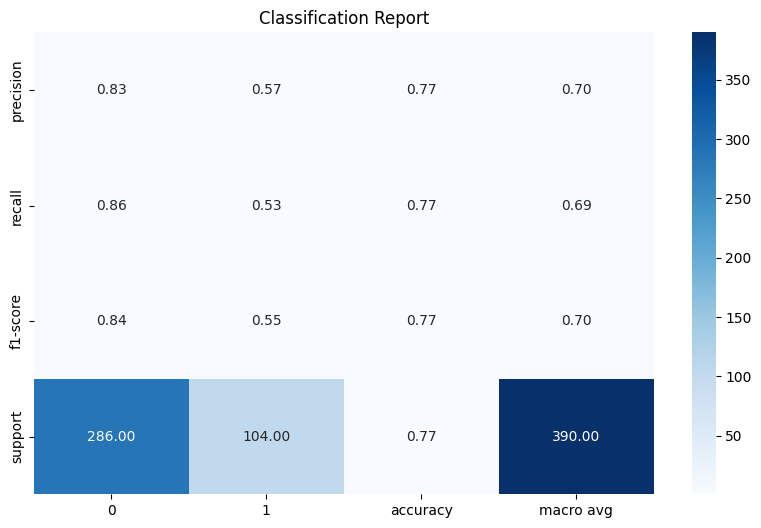

In [146]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f")

plt.title('Classification Report')
plt.show()



In [149]:
score = accuracy_score(y_test, y_pred)

In [150]:
score

0.7692307692307693

In [151]:
# Extraindo as importâncias das features
feature_importances = rf_model.feature_importances_
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Ordenando as features pela importância
features_df = features_df.sort_values(by='Importance', ascending=False)

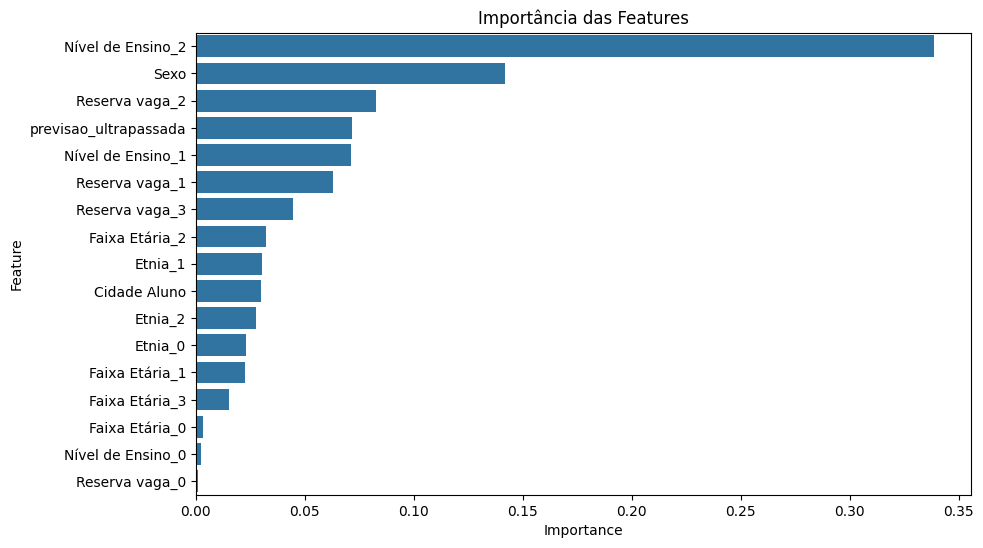

In [152]:
# Plotar as features mais importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)

plt.title('Importância das Features')
plt.show()